# A Code-Centric Introduction to Independent Component Analysis (ICA)

*This is the first in what I'm hoping to make a series of posts on representation learning and unsupervised methods in general. I've noticed that there are far fewer resources out there detailing these topics than there are for common supervised learning topics, and next-to-none that show them off in practice (i.e. with code) along with the underlying math. I'd like these posts to be accessible to a wider audience while still providing mathematical intuition.*

## Part 1: Motivation and Introduction
#### _What is ICA and why would we want to do it?_

Suppose you are at a banquet with $n$ total attendees, all simultaneously engaged in conversation. Should you stand in the middle of this crowd, you will be able to pick out individual voices to tune in and out of at will; however, any microphone positioned in the banquet hall will record an incomprehensible cacaphony, all $n$ voices jumbled together based on their distance from the device. Say you would like to be able to listen to the crowd of voices on a per-speaker basis. With only the one recording, you might<sup>1</sup> be out of luck. If you have recordings from $n$ microphones each placed at different positions rather than one, how can we recover the individual voice signals from every attendee? 

What better way to illustrate this than to listen to some recordings! (The individual source voice signals were created by Google Translate Text-to-Speech and subsequently mixed by me.)

In [1]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from typing import Tuple
import os
import glob
from IPython.display import Audio, display

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
%matplotlib inline

In [4]:
# create convenience function for plotting and playing audio
def show_audio(a: Tuple[int, np.ndarray])->None: # a: (sample_rate, audio_array)
    fig, ax = plt.subplots()
    time_axis = np.linspace(start=0, stop=(len(a[1])/a[0]),num=np.round(len(a[1])))
    ax.plot(time_axis, a[1])
    ax.set_xlabel('Time (seconds)')
    ax.set_ylabel('Amplitude')
    display(Audio(a[1], rate=a[0]))

In [5]:
# collect all the wav files
files = glob.glob('./data/mixed_data/*.wav')

In [6]:
samp_rates = []
sound_list = []

In [7]:
# collect sampling frequencies and audio signals
for f in files:
    samp_rate, sound = wavfile.read(f)
    samp_rates.append(samp_rate)
    sound_list.append(sound)

In [8]:
# store as numpy array
audio_array = np.array(sound_list)

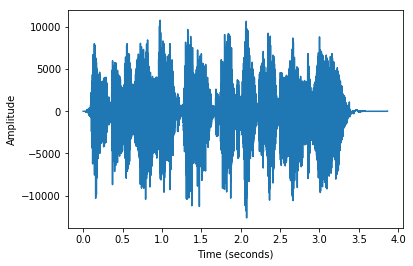

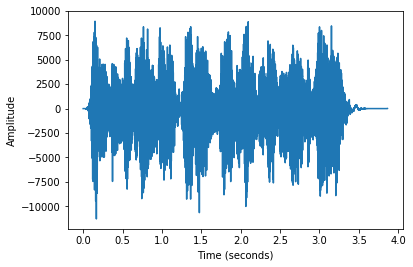

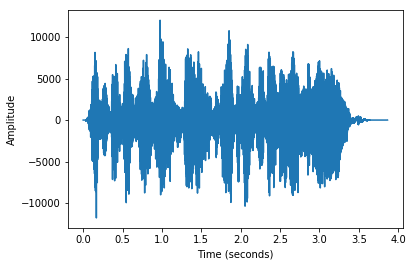

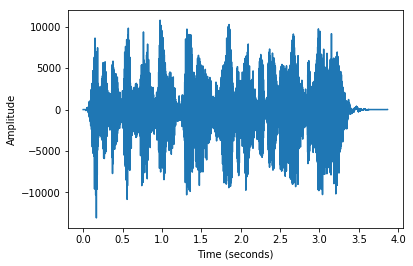

In [9]:
# listen and visualize sound waves as sanity check
for a in zip(samp_rates, sound_list):
    show_audio(a)

Clearly, while we can pick out some of the words being said, these audio clips are a mess.

The general problem of determining sources from observed signals without labels is aptly called _blind source separation_. This specific problem is known as the _cocktail party problem_, and is commonly used to motivate ICA from the perspective of blind source separation<sup>2</sup>.

Let's make this a little more precise. Suppose we have $n$ underlying sources generating our data, e.g. the cocktail party attendees, as well as $n$ references for observing our (mixed) data , e.g. the microphones at different distances from our attendees. If our mixed observations could reasonably be linear combinations of our underlying sources (as would be reasonable here - each microphone's recording is a different linear combination of all the voices depending on how far from the microphone they were), we can represent the situation for each time stamp $t$ as

$$
x^{(t)} = As^{(t)}
$$

where $x$ is the length-$n$ vector of our observed values from every reference at time $t$, $s$ is the (unknown) length-$n$ vector of our underlying source data from every source at time $t$, and $A$ is the (unknown) matrix representing the linear transformation of the sources, known as our _mixing matrix_. Equivalently,

$$
s^{(t)} = Wx^{(t)}
$$

where $W = A^{-1}$. This is the _unmixing matrix_ we will try to learn in order to recover the sources we want from our observed values.

Independent component analysis aims to find a set of sources (i.e. a basis) as statistically independent<sup>3</sup> as possible. In the case of the cocktail party problem, it turns out that different voices talking are close enough to statistically independent that ICA will capture them as its sources.  

While (as we are about to observe) ICA can indeed be a very powerful tool for blind source separation, keep in mind that it also has many other applications such as feature extraction. In particular, we might be interested in ICA as a tool for transforming our data into another form that is more amenable to other algorithms we want to apply; for instance, imagine we want to transcribe all the speech from our room using some (pretrained) speech-to-text algorithm. In the data's current form, this would be hopeless!

## Part 2: Algorithm and Implementation
#### _How do we do ICA?_

### Deriving the Algorithm

So we know we want to find components as independent as possible. What can we do to find these components? Coming from an optimization/machine learning perspective, a first thought might be that we want a cost function that will tell us just _how_ independent a proposed set of components really is. If we had this, we could try to minimize this cost function to find the components we want.

There are many ways of viewing ICA (and coming up with this cost function) which over time have been proven to be equivalent. Here we will use maximum likelihood (per <sup>4</sup>, in turn per <sup>5</sup>) simply because it is a technique that generalizes to many areas of machine learning rather than being highly specific to ICA as some alternative approaches are. 

In a few words, maximum likelihood estimation as a general approach aims to choose parameters that maximize the probability of the observed data. See <sup>4</sup> for a better description.

Let us derive the likelihood for our ICA model. The probability of our data, $p_x(x)$, is

$$
p_x(x) = |\det(W)|p_s(s)
$$

by an elementary result from probability theory on linear transformations of distributions. Encoding our assumption that the source components are independent,

$$
p_x(x) = |\det(W)|p_s(s) = |\det(W)|\prod_{i=1}^n p_s(s_i)
$$

It is often easier computationally to consider the log-likelihood instead of the likelihood; the parameters maximizing both are the same, as the logarithm function is a monotonically increasing function. Incorporating all time stamps $t = \{1,\ldots, T\}$, the log-likelihood of our proposed unmixing matrix $W$ is

$$
L(W) = \sum_{t=1}^T(\sum_{i=1}^n(\log p_s(s_i) + \log |\det(W)| ))
$$

Let's save this as a function for later.

In [10]:
# we use PyTorch tensors so that later we can easily do gradient descent and other fun things
import torch
import torch.utils.data as utils

In [11]:
torch.manual_seed(1)

In [12]:
def log_likelihood(s_pred: torch.Tensor, W: torch.Tensor)->torch.Tensor:
    return torch.sum(torch.log(prob_s(s_pred))) + torch.log(torch.abs(torch.det(W)))

It can be proven that (provided everything has mean zero and variance one, which we will ensure later) as long as our estimate of $p_s$ is on the same side of Gaussian as the true $p_s$ - that is, less tailed (subgaussian) or more tailed (supergaussian) - ICA will manage to sort everything out and correctly find the sources. A supergaussian distribution with good derivative properties that works well is the logistic distribution, whose probability distribution function is the derivative of the sigmoid function <sup>6</sup>.

<figure><img src='//upload.wikimedia.org/wikipedia/commons/thumb/6/66/Logisticpdfunction.svg/480px-Logisticpdfunction.svg.png'><figcaption>The pdf of the logistic distribution for a few different parameters. From Wikipedia https://en.wikipedia.org/wiki/Logistic_distribution</figcaption></figure>


In [13]:
def sigmoid_der(Y: torch.Tensor)->torch.Tensor:
    a = torch.sigmoid(Y)
    b = 1 - torch.sigmoid(Y)
    return a*b
def prob_s(s: torch.Tensor)->torch.Tensor:
    return sigmoid_der(s)

Let's get an intuitive understanding of what these optimal components might look like, if they can be found.
Observe that the sum of non-Gaussian (i.e. non-normally distributed) independent random variables is more Gaussian than its parts. This is guaranteed to us by the Central Limit Theorem, which says that the sum of independent random variables tends toward a Gaussian distribution<sup>7</sup>. As our observed signals are linear combinations of independent sources, if our sources are non-Gaussian, our observations are then more Gaussian than our sources. Thus, we could find by picking $W$ to _minimize the Gaussianity of the proposed sources we obtain_. It turns out this is equivalent to maximizing likelihood. This formulation also makes clear that our algorithm will not work for Gaussian sources (in fact, none will) <sup>8</sup>. 

### Implementation

Now to implementing the algorithm itself! Well, almost. ICA in practice requires a couple of preprocessing steps for nice convergence: centering and whitening. The first of these is simple; we just subtract each element by the mean of the mixed signal it belongs to, thus making new signals each with mean zero. We wanted zero mean to ensure our zero-mean estimate of the probability of the source data is somewhat reasonable.

In [14]:
# zero-mean input
X = audio_array
n, p = X.shape
n_components=min(n,p)
X_mean = X.mean(axis=-1)
X -= X_mean[:, np.newaxis]

The second is slightly more complicated. Whitening in this case is defined as conducting a linear transformation of the (now centered) data such that our new signals are 1) uncorrelated and 2) each have variance one. Intuitively, whitening the input seems to make sense as uncorrelatedness is a weaker form of independence. (Setting the variance to one follows from the same logic as zeroing the mean above.)

In [15]:
# whitening and preprocessing by PCA (i.e. SVD as our data is mean-centered)
# taken from scikit-learn's source code
u, d, _ = linalg.svd(X, full_matrices=False)

del _
K = (u / d).T[:n_components]
del u, d
X1 = np.dot(K, X)
# Here X1 is white and data
# in X has been projected onto a subspace by PCA
X1 *= np.sqrt(p)

With our preprocessing of the input complete, we may now proceed to the algorithm. We will use stochastic gradient descent to minimize the negative log-likelihood (this is equivalent to maximizing the likelihood). 

In [16]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

In [17]:
X1 = torch.tensor(X1,dtype=torch.float)

In [18]:
# we permute the input data to better pretend each of our timestamps was drawn independently - helps with convergence
X1 = X1[:,torch.randperm(X1.shape[1], dtype=torch.long)]

In [19]:
# initialize weights (unmixing matrix)
W = torch.randn(4,4, requires_grad=True, dtype=torch.float)

In [20]:
# prepare dataloader
audio_dataset = utils.TensorDataset(torch.transpose(X1, 0, 1))
audio_dataloader = utils.DataLoader(audio_dataset, shuffle=False)

In [21]:
# set learning rate; SGD can be very finicky depending on this parameter
lr = 0.01

In [22]:
optimizer = torch.optim.SGD([W], lr=lr)

In [23]:
# outer loop: number of times to run through all the samples. In this case, one is enough to get good results.
for t in range(1):
    for idx, x_t in enumerate(audio_dataloader):
        x_t = x_t[0]
        x_t = torch.transpose(x_t, 0, 1)
        
        # forward pass
        Y_pred = torch.mm(W, x_t)
        # compute loss
        # todo: try computing loss by loading time stamps in as training examples in shuffled order instead of whole matrix at once
        log_likelihood = torch.sum(torch.log(sigmoid_der(Y_pred))) + torch.log(torch.abs(torch.det(W)))
        #log_likelihood = log_likelihood(Y_pred, W)
        loss = -log_likelihood
        #print(t, loss)
        
        # good to check that our values are still sane and nothing has gone horribly wrong
        if torch.isnan(loss).any() or loss.item() == np.inf or loss.item() == -np.inf:
            print('Gradient vanished/exploded')
            raise Exception('Ded')
            break

        prev_loss = loss
        # compute gradient for gradient descent
        loss.backward()
        #print(W.grad)
        #print(t, W.grad)
        # recompute W in 'descent' step of gradient descent
        optimizer.step()
        optimizer.zero_grad()

We've found our $W$! Now all that's left is to transform our mixed reference data to our derived sources.

In [32]:
# unwhiten W and calculate source signals
S_2 = np.dot(np.dot(W.detach().numpy(), K), X)

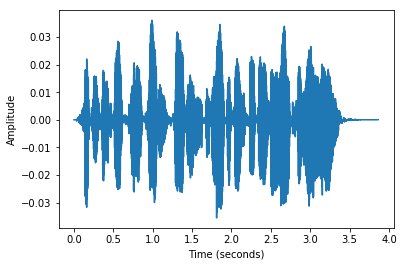

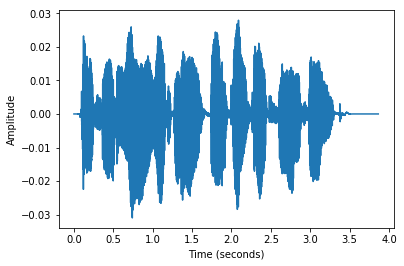

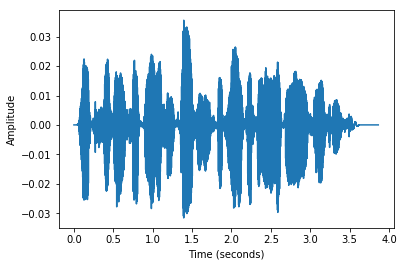

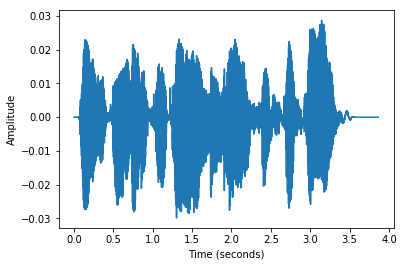

In [33]:
for idx, row in enumerate(S_2):
    show_audio((samp_rate, row))

And there you have it - each separate voice as a separate signal, perfect for transcription or whatever other task you'd like to do. (This also illustrates another important property of ICA: unlike in other methods such as PCA, the order of the components we get out is arbitrary. If you listen to each clip, you should be able to figure out what order I made them in!)

I think it's important to note here that there are much better algorithms than gradient descent for deriving independent components, namely FastICA <sup>9</sup>. However, I used gradient descent here very intentionally. With the code written down in this form, doesn't it look very familiar?

I hope it's clear that this resembles a one-layer neural network with a single linear layer and no nonlinearities. We used gradient descent to approximate a linear transformation; deeper neural networks with nonlinearities can be thought of as the application of gradient descent (or whatever optimization algorithm you like best, it doesn't matter) to approximate more complex functions. For blind source separation of audio, linear mixing (and thus unmixing) seems like a reasonable model, but it is easy to imagine other problems in which sources might be combined in some way that's highly nonlinear.

My first thought when learning about ICA was that we might want to use a proper neural network to learn a more complex invertible unmixing function. I think writing the code for linear ICA in this way makes the intuition for this idea more obvious than any other presentation I have found. Unfortunately other people also thought of this idea and have written papers on it, including this nice piece from Yoshua Bengio's lab <sup>10</sup>; fortunately that means it is a good idea, and I have more to read/write about. I plan on spending a while playing with this - if I get interesting results it might become my next post! For now, I hope this served as a good introduction to/refresher of linear ICA.

_Major credit to Aapo Hyvärinen and Erkki Oja for inspiring this post: most of this explanation is based on my understanding of their 'Independent Component Analysis: Algorithms and Applications' (https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf). I also referred to Andrew Ng's CS229 lecture notes on ICA as well as the Wikipedia page on the subject._

## Footnotes
1. This is an active area of research. For one interesting approach highly related to the form of ICA presented here, see http://www.jmlr.org/papers/v4/jang03a.html.
2. As in https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf, or http://cs229.stanford.edu/notes/cs229-notes11.pdf, or https://en.wikipedia.org/wiki/Independent_component_analysis, or pretty much any other introduction to ICA in existence.
3. See https://en.wikipedia.org/wiki/Independence_(probability_theory) to get a refresher on statistical independence.
4. Goodfellow, I., Bengio, Y., and Courville, A. (2016). _Deep learning_. Cambridge, MA: MIT Press.
5. Pham, D.-T., Garrat, P., and Jutten, C. (1992). Separation of a mixture of independent sources through a maximum likelihood approach. In _Proc. EUSIPCO_, pages 771–774.
6. http://cs229.stanford.edu/notes/cs229-notes11.pdf
7. http://blog.vctr.me/posts/central-limit-theorem.html provides a really nice visualization of this. Also note that it is not _always_ true (the full Central Limit Theorem has some caveats) but for our purposes it is good enough to take it at face value.
8. This is not exactly true; we can have exactly one be Gaussian, which we can think of as all the Gaussian-ness stuck into one component after the others are optimized for non-Gaussianity. Refer to Hyvärinen again. https://www.cs.helsinki.fi/u/ahyvarin/papers/NN00new.pdf
9. Hyvärinen again (in the same citation no less), he came up with this one. In case you haven't noticed, he's sort of a big deal in ICA.
10. Dinh, L., Krueger, D., and Bengio, Y. (2015). NICE: Non-linear Independent Components Estimation. https://arxiv.org/abs/1410.8516 (Nice, isn't it?)
